In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [2]:
application = pd.read_csv("application_record.csv")
credit = pd.read_csv("credit_record.csv")

In [3]:
application

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


## Vintage Analysis, assigning label to each example

In [4]:
grouped = credit.groupby('ID')
### convert credit data to wide format which every ID is a row
pivot_tb = credit.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min() # smallest value of MONTHS_BALANCE, is the month when loan was granted
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max() # biggest value of MONTHS_BALANCE, might be observe over or canceling account
pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID', 'open_month', 'end_month']]
pivot_tb['window'] = pivot_tb['end_month'] - pivot_tb['open_month'] # calculate observe window
pivot_tb.reset_index(drop = True, inplace = True)
credit = pd.merge(credit, pivot_tb, on = 'ID', how = 'left') # join calculated information
credit0 = credit.copy()
credit = credit[credit['window'] > 20] # delete users whose observe window less than 20
credit['status'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0) # analyze > 60 days past due 
credit['status'] = credit['status'].astype(np.int8) # 1: overdue 0: not
credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month'] # calculate month on book: how many months after opening account
credit.sort_values(by = ['ID','month_on_book'], inplace = True)

##### denominator
denominator = pivot_tb.groupby(['open_month']).agg({'ID': ['count']}) # count how many users in every month the account was opened
denominator.reset_index(inplace = True)
denominator.columns = ['open_month','sta_sum']

##### vintage table
vintage = credit.groupby(['open_month','month_on_book']).agg({'ID': ['count']}) 
vintage.reset_index(inplace = True)
vintage.columns = ['open_month','month_on_book','sta_sum'] 
vintage['due_count'] = np.nan
vintage = vintage[['open_month','month_on_book','due_count']] # delete aggerate column
vintage = pd.merge(vintage, denominator, on = ['open_month'], how = 'left') # join sta_sum colun to vintage table

In [5]:
larger_window = abs(vintage['open_month'].min())
for j in range(-larger_window,1): # outer loop: month in which account was opened
    ls = []
    for i in range(0,larger_window+1): # inner loop time after the credit card was granted
        due = list(credit[(credit['status'] == 1) & (credit['month_on_book'] == i) & (credit['open_month'] == j)]['ID']) # get ID which satisfy the condition
        ls.extend(due) # As time goes, add bad customers
        vintage.loc[(vintage['month_on_book'] == i) & (vintage['open_month'] == j), 'due_count'] = len(set(ls)) # calculate non-duplicate ID numbers using set()
        
vintage['sta_rate']  = vintage['due_count'] / vintage['sta_sum'] # calculate cumulative % of bad customers        

In [6]:
def calculate_observe(credit, command):
    '''calculate observe window
    '''
    larger_window = abs(credit['MONTHS_BALANCE'].min())
    id_sum = len(set(pivot_tb['ID']))
    credit['status'] = 0
    exec(command)
    #credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month']
    minagg = credit[credit['status'] == 1].groupby('ID')['month_on_book'].min()
    minagg = pd.DataFrame(minagg)
    minagg['ID'] = minagg.index
    obslst = pd.DataFrame({'month_on_book':range(0,larger_window + 1), 'rate': None})
    lst = []
    for i in range(0,larger_window + 1):
        due = list(minagg[minagg['month_on_book']  == i]['ID'])
        lst.extend(due)
        obslst.loc[obslst['month_on_book'] == i, 'rate'] = len(set(lst)) / id_sum 
    return obslst['rate']

command = "credit.loc[(credit['STATUS'] == '0') | (credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_observe(credit, command)

In [7]:
def calculate_rate(pivot_tb, command): 
    '''calculate bad customer rate
    '''
    credit0['status'] = None
    exec(command) # excuate input code
    sumagg = credit0.groupby('ID')['status'].agg(sum)
    pivot_tb = pd.merge(pivot_tb, sumagg, on = 'ID', how = 'left')
    pivot_tb.loc[pivot_tb['status'] > 1, 'status'] = 1
    rate = pivot_tb['status'].sum() / len(pivot_tb)
    return round(rate, 5)

command = "credit0.loc[(credit0['STATUS'] == '0') | (credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_rate(pivot_tb, command)

In [8]:
#"Bad" client are identified as client that past due more than 30 days
y = credit0[['ID','STATUS','status']].copy()
y['status'] = 0 #0 is the label for a "good" client
exec("y.loc[(y['STATUS'] == '1') | (y['STATUS'] == '2') | (y['STATUS'] == '3' )| (y['STATUS'] == '4' )| (y['STATUS'] == '5'), 'status'] = 1") #1 is the label for a "Bad" client
y = y[['ID','status']].rename(columns={"ID": "ID", "status": "target"})

In [9]:
y

,ID,target
0,5001711,0
1,5001711,0
2,5001711,0
3,5001711,0
4,5001712,0
...,...,...
1048570,5150487,0
1048571,5150487,0
1048572,5150487,0
1048573,5150487,0


## Features engineering

In [10]:
application.replace(['N', 'Y'], [0, 1], inplace=True) 

In [11]:
application.replace(['M', 'F'], [0, 1], inplace=True) 

In [12]:
application.replace(['Academic degree', 'Higher education', 'Incomplete higher', 
                'Secondary / secondary special', 'Lower secondary'], [4, 3, 2, 1, 0], inplace=True)

In [13]:
application['OCCUPATION_TYPE'].fillna('NA', inplace=True)

In [14]:
application = pd.get_dummies(application)

In [15]:
application

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_NA,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,5008804,0,1,1,0,427500.0,3,-12005,-4542,1,...,0,0,0,1,0,0,0,0,0,0
1,5008805,0,1,1,0,427500.0,3,-12005,-4542,1,...,0,0,0,1,0,0,0,0,0,0
2,5008806,0,1,1,0,112500.0,1,-21474,-1134,1,...,0,0,0,0,0,0,0,0,1,0
3,5008808,1,0,1,0,270000.0,1,-19110,-3051,1,...,0,0,0,0,0,0,1,0,0,0
4,5008809,1,0,1,0,270000.0,1,-19110,-3051,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,0,0,1,0,135000.0,1,-22717,365243,1,...,0,0,0,1,0,0,0,0,0,0
438553,6840222,1,0,0,0,103500.0,1,-15939,-3007,1,...,0,0,0,0,0,0,0,0,0,0
438554,6841878,1,0,0,0,54000.0,3,-8169,-372,1,...,0,0,0,0,0,0,1,0,0,0
438555,6842765,1,0,1,0,72000.0,1,-21673,365243,1,...,0,0,0,1,0,0,0,0,0,0


In [16]:
application['AMT_INCOME_TOTAL'].describe()

count    4.385570e+05
mean     1.875243e+05
std      1.100869e+05
min      2.610000e+04
25%      1.215000e+05
50%      1.607805e+05
75%      2.250000e+05
max      6.750000e+06
Name: AMT_INCOME_TOTAL, dtype: float64

In [17]:
X_y = application.merge(y, how='inner', on="ID")

In [18]:
X_y.drop("ID", axis=1, inplace=True)

In [19]:
X, Y = X_y.values[:, :-1], X_y.values[:, -1]

In [20]:
# !pip install imblearn

In [21]:
# oversamppling to balance 1 and 0
from imblearn.over_sampling import SMOTE
ros = SMOTE()
X_resampled, y_resampled = ros.fit_resample(X, Y)

In [22]:
pd.DataFrame(Y).describe()

,0
count,777715.000000
mean,0.014883
std,0.121086
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [23]:
Y[Y == 1].shape

(11575,)

In [24]:
y_resampled[y_resampled == 0].shape

(766140,)

In [25]:
y_resampled[y_resampled == 1].shape

(766140,)

In [26]:
pd.DataFrame(y_resampled).describe()

,0
count,1532280.0
mean,0.5
std,0.5
min,0.0
25%,0.0
50%,0.5
75%,1.0
max,1.0


In [27]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25)

mm_sc = MinMaxScaler()
X_train_sc = mm_sc.fit_transform(X_train)

## Logistic Regression

/Users/Ashley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


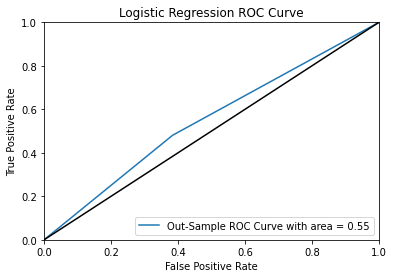

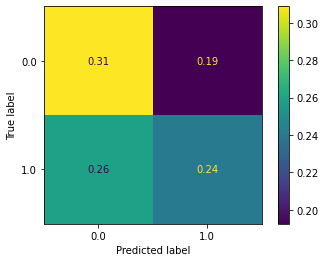

In [28]:
mm_sc = MinMaxScaler()
X_train_sc = mm_sc.fit_transform(X_train)

log_c = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True,
                          intercept_scaling=1, solver='lbfgs')

log_c.fit(X_train_sc, y_train)

X_test_sc = mm_sc.transform(X_test)
y_pred = log_c.predict(X_test_sc)

# plot ROC
from sklearn.metrics import roc_curve, auc
testing_predictions = log_c.predict(X_test_sc)
(fpr, tpr, thresholds) = roc_curve(y_test,testing_predictions)

area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc="lower right")
plt.show()

# metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, normalize='all')

plot_confusion_matrix(log_c, X_test_sc, y_test, normalize='all');
plt.show()

## Random Forests

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

rforest = RandomForestClassifier(n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,)
sd_sc = MinMaxScaler()
X_train_sc = sd_sc.fit_transform(X_train)

In [30]:
rforest.fit(X_train_sc,np.ravel(y_train))

RandomForestClassifier()

In [31]:
X_test_sc = sd_sc.fit_transform(X_test)
predictions = rforest.predict(X_test_sc)
predictions

array([0., 1., 1., ..., 0., 0., 0.])

In [32]:
actuals = y_test
actuals

array([0., 1., 1., ..., 0., 0., 0.])

[[168107  23937]
 [ 12554 178472]]


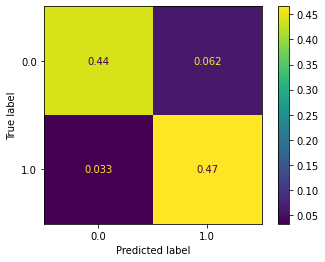

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

print(confusion_matrix(actuals, predictions))
plot_confusion_matrix(rforest, X_test_sc, actuals, normalize='all')

In [34]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
print(accuracy_score(actuals, predictions))
print(f1_score(actuals, predictions))
print(recall_score(actuals, predictions))
print(precision_score(actuals, predictions))

0.9047406479233561
0.9072502446401565
0.9342811973239245
0.8817394483446882


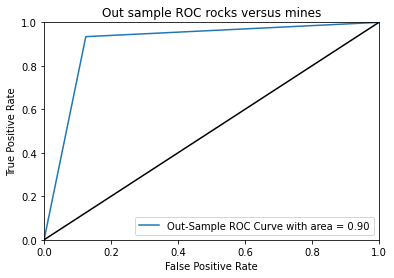

In [35]:
from sklearn.metrics import roc_curve, auc
testing_predictions = rforest.predict(X_test_sc)
(fpr, tpr, thresholds) = roc_curve(y_test,testing_predictions)

area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Out sample ROC rocks versus mines')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 0, 'Relative Importance')

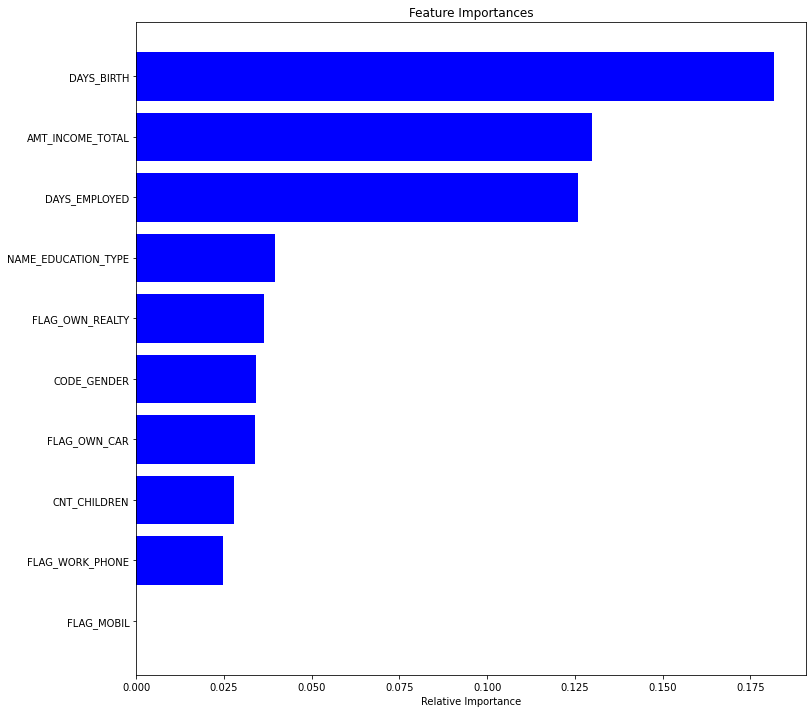

In [36]:
feature_names = [key for key in X_y if not key=='target']
import matplotlib.pyplot as plt
%matplotlib inline
importances = rforest.feature_importances_[:10]
indices = np.argsort(importances)[:10]
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)),feature_names)
plt.yticks(range(len(indices)),np.array(feature_names)[indices])
plt.xlabel('Relative Importance')

## Neural Networks

In [37]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(200,200,200), max_iter = 100, random_state=1, validation_fraction=0.2, early_stopping=True)

In [38]:
clf.fit(X_train_sc, y_train)

MLPClassifier(alpha=1e-05, early_stopping=True,
              hidden_layer_sizes=(200, 200, 200), max_iter=100, random_state=1,
              validation_fraction=0.2)

In [39]:
X_test_sc = mm_sc.transform(X_test)
predictions = clf.predict(X_test_sc)
predictions

array([0., 1., 1., ..., 0., 0., 0.])

In [40]:
actuals = y_test
actuals

array([0., 1., 1., ..., 0., 0., 0.])

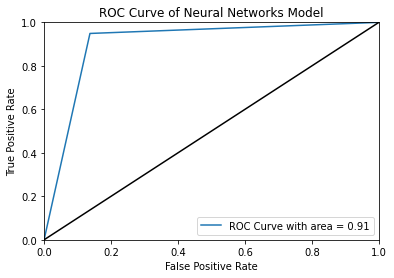

In [41]:
from sklearn.metrics import roc_curve, auc
testing_predictions = predictions
(fpr, tpr, thresholds) = roc_curve(y_test,testing_predictions)

area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="ROC Curve with area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Neural Networks Model')
plt.legend(loc="lower right")
plt.show()

[[165727  26317]
 [  9746 181280]]


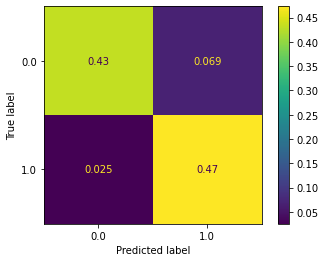

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

print(confusion_matrix(actuals, predictions))
plot_confusion_matrix(clf, X_test_sc, actuals, normalize='all')

In [43]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
print(accuracy_score(actuals, predictions))
print(recall_score(actuals, predictions))
print(precision_score(actuals, predictions))
print(f1_score(actuals, predictions))

0.905857937191636
0.9489807670160083
0.8732303453325433
0.9095310606763783
